# The Stability of the Planetary Orbits

## Call the C library ODE solver

In [77]:
import ctypes
from ctypes import *
from numpy.ctypeslib import ndpointer
import numpy as np
import matplotlib.pyplot as plt
import numba
import csv
import random

import deep_nn
importlib.reload(deep_nn)

In [33]:
# set formatting of the plots

In [6]:
!gcc -shared -O2 ode.c -o libode.so

In [7]:
#load our C library, it's as simple as that!
lib = ctypes.CDLL("libode.so")
#rename C-based solve_ode() function into solve_ode_c()
solve_ode_c = lib.solve_ode
#in order to call a C function, we need to define:
# * the return data type
solve_ode_c.restype = None
# * function argument types
solve_ode_c.argtypes = [
    ndpointer(ctypes.c_double), 
    ndpointer(ctypes.c_double),
    ctypes.c_double,
    ctypes.c_int,
    ctypes.c_int,
    ctypes.c_int,
    ndpointer(ctypes.c_double),
    ctypes.CFUNCTYPE(None,c_double, POINTER(c_double), POINTER(c_double), POINTER(c_double))
]

#In order to "hide" from the end user the C "guts" of the library, 
#let's create a python "wrapper function" for our ODE solver
def solve_ode(fun, t_span, nsteps, z0, method = "RK4", args = None ):
    """
    Takes in the right-hand side function fun, the time range t_span, 
    the number of time steps nsteps, and the initial condition vector z0.
    
    Keyword arguments: 
    method -- one of "Euler", "Euler-Cromer", "RK2", "RK4", etc ODE solution methods
    args   -- arguments to pass to the right-hand side function fun()
    
    Returns: the pair t,z of time and solution vector.
    """
    t_span = np.asarray(t_span,dtype=np.double)
    t = np.linspace(t_span[0],t_span[1],nsteps+1,dtype=np.double)
    nvar = len(z0)
    z = np.zeros([nsteps+1,nvar],dtype=np.double,order='C')
    #assign initial conditions
    z0 = np.asarray(z0,dtype=np.double)
    z[0,:] = z0
    #check if the supplied function is numba-based CFunc
    if("ctypes" in dir(fun)):
        #numba-based, we can use it right away
        fun_c = fun.ctypes
    else:
        #otherwise, we need to wrap the python function into CFUNCTYPE
        FUNCTYPE = CFUNCTYPE(None,c_double, POINTER(c_double), POINTER(c_double), POINTER(c_double))
        #create a C-compatible function pointer
        fun_c = FUNCTYPE(fun)
    #compute preliminaries to call the C function library
    dt = (t_span[1]-t_span[0])/nsteps
    if args is not None: args = np.asarray(args,dtype=np.double)
    if method in ["RK2", "RKO2"]:
        order = 2
    elif method in ["Euler"]:
        order = 1
    elif method in ["Euler-Cromer"]:
        order = -1
    elif method in ["Velocity Verlet"]:
        order = 13
    elif method in ["Leapfrog"]:
        order = 5
    elif method in ["RK4"]:
        order = 4
    elif method in ["Yoshida4"]:
        order = 6
    else:
        #default
        order = 13
    
    #make a call to the C library function
    solve_ode_c(t,z,dt,nsteps,nvar,order,args,fun_c)

    return t,z

## Define the right-hand side of the equation of motion: $\frac{d\vec z}{dt} = \vec f(t,\vec z)$

### Mercury, Venus, Earth, Mars, Jupiter, Saturn, and the Sun

In [23]:
#This has been updated to use numba, which compiles the below function on the fly
#and substantially speeds up the ODE integration
from numba import cfunc, types

c_sig = types.void(types.double,
                   types.CPointer(types.double),
                   types.CPointer(types.double),
                   types.CPointer(types.double))

@cfunc(c_sig)
def funcpl(t,z,params,dzdt):
    """
    Takes the time and solution vector z, as well as parameters in the params array, 
    and populates the dzdt array with the values of the right-hand side function f(t,z).
    
    This function returns the right-hand side f(t,z) for a planet subject to graviational
    force due to the center body with GM_S = 4 pi^2
    
    The system:
    - the Sun
    - Mercury with an elliptic orbit
    - Venus, Earth, Mars, Jupiter, Saturn with circular orbits (radius = semi-major axis)
    
    Note: Venus is rotating in the opposite direction
    
    The order:
    0 Venus, 1 Earth, 2 Mars, 3 Jupiter, 4 Saturn
    
    params[i*3    ] = Mass of the planet in solar masses
    params[i*3 + 1] = Semi-major axis of the orbit in AU
    params[i*3 + 2] = Period of rotation in years
    
    Returns: nothing
    """
    xm  = z[0]
    Vmx = z[1]
    ym  = z[2]
    Vmy = z[3]
    
    rm = np.sqrt(xm**2 + ym**2)
    
    dzdt[0] = Vmx
    dzdt[1] = -4. * (np.pi ** 2) * xm / (rm ** 3)
    dzdt[2] = Vmy
    dzdt[3] = -4. * (np.pi ** 2) * ym / (rm ** 3)
    
    # compute coordinates of planets other than Mercury
    for plan in range(0,5):
        x_pl = params[plan*3 + 1] * np.cos(2. * np.pi * t / params[plan*3 + 2])
        y_pl = params[plan*3 + 1] * np.sin(2. * np.pi * t / params[plan*3 + 2])
        if plan == 0:
            y_pl *= -1

        r_mpl = np.sqrt( (xm - x_pl) ** 2 + (ym - y_pl) ** 2)
        
        dzdt[1] += - 4. * (np.pi ** 2) * params[plan*3] * (xm - x_pl) / (r_mpl ** 3)
        dzdt[3] += - 4. * (np.pi ** 2) * params[plan*3] * (ym - y_pl) / (r_mpl ** 3)

## Transform coordinates

In [10]:
def ellipse_to_xy(a,e,theta,thetaE):
    """
    Takes the particle's position relative to an ellipse and parameters of the ellipse a,e,theta,theta_E.
    This function returns the Cartesian variables x,V_x,y,V_y.
    
    Returns x,Vx,y,Vy
    """

    # radius using angle theta
    r = a * (1 - e**2) / (1 + e * np.cos(theta - thetaE))
    
    # angular momentum per mass
    h = 2. * np.pi * np.sqrt(np.abs(a * (1. - e **2)))
    
    # energy per mass
    u = - 2. * (np.pi ** 2) / a 
    
    # speed of the particle
    V = np.sqrt(np.abs(2. * u + 8. * (np.pi ** 2) / r)) 
    
    # let Vx = V cos alpha, Vy = V sin alpha
    # buff = alpha - theta
    # when the radial velocity is positive (the planet goes from its periapse to apoapse = sin(theta-theta_E) > 0)
    # alpha - theta should be less then pi/2
    buff_sin = np.array(h / (r * V))
    
    # to make sure that arcsin takes values less than 1 and greater than -1
    buff_sin[buff_sin < -1.] = -1.
    buff_sin[buff_sin > 1.] = 1.
    
    buff = np.pi*(np.sin(theta - thetaE) < 0.) + np.power(-1., np.sin(theta - thetaE) < 0.) * np.arcsin(buff_sin)
    alpha = theta + buff
        
    # x and y
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    
    # Vx and Vy
    Vx = V * np.cos(alpha)
    Vy = V * np.sin(alpha)
    
    return x,Vx,y,Vy

In [11]:
def xy_to_ellipse(x,Vx,y,Vy):
    """
    Takes the Cartesian variables.
    This function returns the particle's position relative to an ellipse and parameters of the ellipse.
    
    Returns a,e,theta,theta_E
    """
    # radius using x and y
    r = np.sqrt(x ** 2 + y ** 2)
    
    # speed of the particle
    V = np.sqrt(Vx ** 2 + Vy ** 2)
    
    # angular momentum per mass
    h = x * Vy - y * Vx
    
    # energy per mass
    u = (V ** 2) / 2. - 4. * (np.pi ** 2) / r
    
    # semi-major axis
    a = -2. * ((np.pi) ** 2) / u
    
    # eccentricity of the elliptical orbit, added absolute value
    e = np.sqrt(np.abs(1 - ((h / (2. * np.pi)) ** 2 )/ a))
    
    # theta
    theta = np.arctan2(y,x)
    
    # theta_E, compute e*cos(theta - thetaE) first
    buff = a * (1. - e ** 2) / r - 1.
    
    # divide buff/e and output 0 if it is a circular orbit
    buff_cos = np.divide(buff, e, out=np.zeros_like(buff), where=(e > np.power(10.,-5.)))
    
    #to make sure that arccos takes values less than 1 and greater than -1
    buff_cos[buff_cos < -1.] = -1.
    buff_cos[buff_cos > 1.] = 1.
    
    delta = np.arccos(buff_cos)
    
    # change the sign if the radial velocity is negative
    delta *= np.power(-1.,(x * Vx + y * Vy) < 0.)
    thetaE = theta - delta
    
    # set thetaE to 0 if it is a circular orbit
    thetaE *= (e > np.power(10.,-5.))
    
    # fix to add 2pi or subtract 2pi if thetaE isn't between -pi and pi
    thetaE -= (thetaE > np.pi) * 2 * np.pi
    thetaE += (thetaE < -np.pi) * 2 * np.pi
    
    return a,e,theta,thetaE

## Run the simulation

### Initial conditions:
##### Mercury  $a_m=0.39 AU, \ e_m=0.206, \ \theta_E = -3\pi/4, \ \theta_m=\theta_E$
##### Venus $M_V = 0.000002447M_S, \ a_V = 0.72 AU, \ T_V = 0.615 years,\ \theta_V = 0$
##### Earth $M_E = M_S/333030, \ a_E = 1 AU, \ T_E = 1 years,\ \theta_E = 0$
##### Mars $M_M = 0.0000003213M_S, \ a_M = 1.52 AU, \ T_M = 1.88 years,\ \theta_M = 0$
##### Jupiter $M_J = M_S/1048, \ a_J = 5.20 AU, \ T_J = 11.86 years,\ \theta_J = 0$
##### Saturn $M_S = 0.0002857M_S, \ a_S = 9.58 AU, \ T_J = 29.46 years,\ \theta_J = 0$

In [63]:
# compute initial conditions of Mercury in cartesian coordinates
am = 0.39
em = 0.206
thetaEm = -3 * np.pi / 4.
thetam = thetaEm

init_cart = np.array(ellipse_to_xy(am,em,thetam,thetaEm))
planets = np.array([0.000002447, 0.72, 0.615,
                    1./333030., 1., 1.,
                    0.0000003213, 1.52, 1.88,
                    1./1048., 5.20, 11.86,
                    0.0002857, 9.58, 29.46])

In [64]:
# run the simulation
dt = 0.001
time_f = 10000.
nsteps = int(time_f/dt)
t,zm = solve_ode(funcpl,[0.,time_f], nsteps, init_cart, args=planets, method="Yoshida4")
xm,Vmx,ym,Vmy = zm.T

# compute the parameters of the ellipse
a,e,theta,thetaE = xy_to_ellipse(xm,Vmx,ym,Vmy)

(-10.0, 10.0)

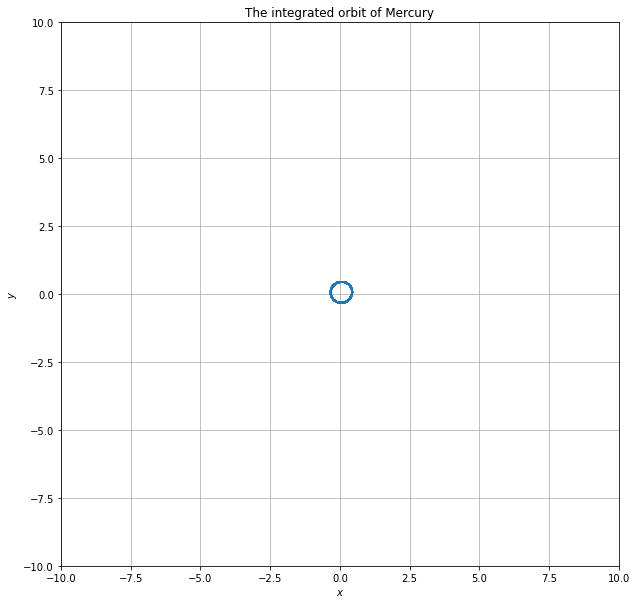

In [65]:
plt.figure(figsize=(10,10))
plt.title(r"The integrated orbit of Mercury")
plt.ylabel(r"$y$")
plt.xlabel(r"$x$")

plt.plot(xm,ym)
#plt.legend()
plt.grid()

axes = plt.gca()
axes.set_xlim([-10,10])
axes.set_ylim([-10,10])

#plt.savefig("mercury_planets.png")

## Labeling the data
##### Decide whether Mercury is still on the orbit

In [74]:
int(np.count_nonzero((a>10))==0)

1

## Running the simulations with small pertubations
##### Modify the initial conditions of Mercury

In [78]:
thetaEm = -3 * np.pi / 4.
thetam = thetaEm
init_cart = np.array(ellipse_to_xy(am,em,thetam,thetaEm))
planets = np.array([0.000002447, 0.72, 0.615,
                    1./333030., 1., 1.,
                    0.0000003213, 1.52, 1.88,
                    1./1048., 5.20, 11.86,
                    0.0002857, 9.58, 29.46])

dt = 0.001
time_f = 10000.
nsteps = int(time_f/dt)

for iteration in range(0,1000):
    # add small pertubations to Mercury
    am = random.gauss(0.39, 0.01)
    em = random.gauss(0.206, 0.001)
    init_cart = np.array(ellipse_to_xy(am,em,thetam,thetaEm))
    
    # run the simulation
    t,zm = solve_ode(funcpl,[0.,time_f], nsteps, init_cart, args=planets, method="Yoshida4")
    xm,Vmx,ym,Vmy = zm.T

    # compute the parameters of the ellipse
    a,e,theta,thetaE = xy_to_ellipse(xm,Vmx,ym,Vmy)
    
    # 1 if stable, 0 if unstable
    stability = int(np.count_nonzero((a>10))==0)
    
    with open('train.csv', mode='a') as file:
        writer = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

        data = [am, em, stability]
        writer.writerow(data)

## Predicting the stability of the system